# `Итоговый проект Черепановой Ирины`


**Прогноз расхода энергии по временным рядам**

# 📈 Введение в прогнозирование временных рядов 




## Что такое Прогнозирование временных рядов?
Прогнозирование временных рядов происходит, когда вы делаете научные прогнозы на основе исторических данных с отметками времени. Это включает в себя построение моделей на основе исторического анализа и их использование для проведения наблюдений и принятия будущих стратегических решений.

**Применение прогнозирования временных рядов :**

Прогнозирование имеет широкий спектр применений в различных отраслях промышленности. Он имеет множество практических применений, включая: прогнозирование погоды, прогнозирование климата, экономическое прогнозирование, прогнозирование здравоохранения, инженерное прогнозирование, финансовое прогнозирование и многое другое!



**Описание проекта**

**Цель проекта** - Спрогнозировать потребление электроэнергии США, используя более точную модель. Узнать о прогнозировании временных рядов путем анализа потребления энергии в Соединенных Штатах в период с 2015 по 2019 год.

Потребление энергии выражается в мегаваттах (МВт), и у нас есть данные, доступные за все часы.
Мы начнем с анализа временных рядов, а затем с определенной степенью неопределенности спрогнозироваем будущее потребление.

## Содержание

* [Part 1 : Исследовательский анализ данных (EDA) ](#chapter1)

* [Part 2 : Прогноз модели Prophnet](#chapter2)

* [Part 3 : Прогноз модели : с помощью модель SARIMAX](#chapter3)

* [Part 4 : Прогноз модели : с помощью LASSO (L1) Regression](#chapter4)

* [Part 5 : Выводы](#chapter5)


# Часть 1 : Исследовательский анализ данных (EDA)  <a class="anchor" id="chapter1"></a>

In [ ]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

In [ ]:
pjme = pd.read_csv('/content/drive/MyDrive/PJME_hourly.csv',index_col=[0], parse_dates=[0])
start_date = '01-Jan-2008'
pjme = pjme.loc[pjme.index >= start_date]
pjme=pjme.reset_index()
pjme.head()

In [ ]:
pjme = pd.read_csv('/content/drive/MyDrive/PJME_hourly.csv',index_col=[0], parse_dates=[0])
start_date = '01-Jan-2008'
pjme = pjme.loc[pjme.index >= start_date]
pjme=pjme.reset_index()
pjme.head()

,Datetime,PJME_MW
0,2008-01-01 00:00:00,30998.0
1,2008-12-31 01:00:00,28937.0
2,2008-12-31 02:00:00,27714.0
3,2008-12-31 03:00:00,27120.0
4,2008-12-31 04:00:00,26995.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!wget https://dropmefiles.com/qOl5y 

In [ ]:
pjme.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92795 entries, 0 to 92794
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Datetime  92795 non-null  datetime64[ns]
 1   PJME_MW   92795 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 MB


Построим временной ряд

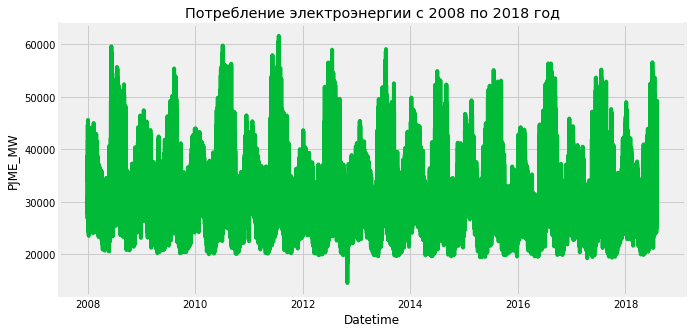

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.lineplot(x=pjme.Datetime, y = pjme["PJME_MW"], color = "#00BA38")
ax.title.set_text('Потребление электроэнергии с 2008 по 2018 год')

Создадим коллекцию новых переменных:
date equal to the Datetime

*   date равно дате времени
*   hour равный часу дня
*   dayofweek
*   quarter
*   month
*   year
*   dayofyear
*   dayofmonth
*   weekofyear

Создадим X, содержащий вышеуказанные переменные, и y, содержащий временные ряды

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df['date'] = df.Datetime
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['date','hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear']]
    
    if label:
        y = df[label]
        return X, y
    return X

Создадим объект features_and_target, содержащий оба параметра, и отобразите первые несколько строк

In [ ]:

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)
features_and_target.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
0,2008-01-01 00:00:00,0,1,1,1,2008,1,1,1,30998.0
1,2008-12-31 01:00:00,1,2,4,12,2008,366,31,1,28937.0
2,2008-12-31 02:00:00,2,2,4,12,2008,366,31,1,27714.0
3,2008-12-31 03:00:00,3,2,4,12,2008,366,31,1,27120.0
4,2008-12-31 04:00:00,4,2,4,12,2008,366,31,1,26995.0


Построим временной ряд по часам, дням недели, годам, неделям года

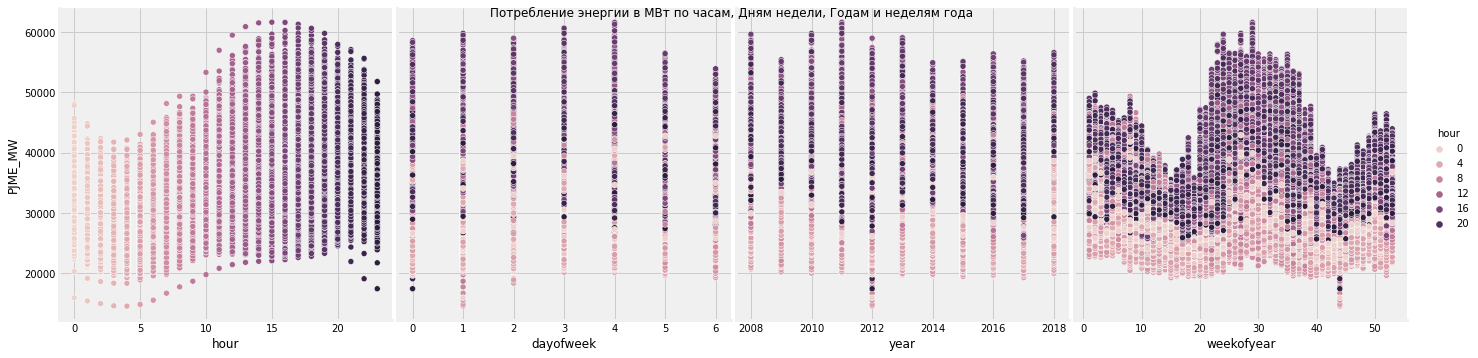

In [ ]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek','year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
            )
plt.suptitle('Потребление энергии в МВт по часам, Дням недели, Годам и неделям года')
plt.show()

Отрежем данные после 2015 года, чтобы использовать их в качестве нашего набора для проверки. Мы будем тренироваться на более ранних данных.

In [ ]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.date <= split_date].copy()
pjme_test = pjme.loc[pjme.date > split_date].copy()

построим серию с разными цветами  train и test, чтобы визуализировать разделение.

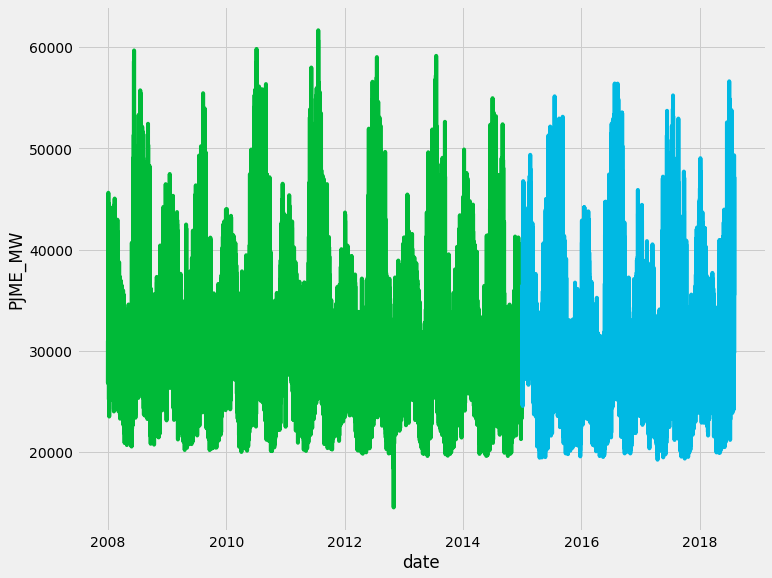

In [ ]:
# построим train и test, чтобы увидеть разделение
sns.lineplot(x = pjme_train.date, y = pjme_train["PJME_MW"], color = "#00BA38")
sns.lineplot(x = pjme_test.date, y = pjme_test["PJME_MW"], color = "#00B9E3")

# Часть 2 : Прогноз модели : с помощью Prophet  <a class="anchor" id="chapter2"></a>

Библиотека Prophet - это библиотека с открытым исходным кодом, предназначенная для составления прогнозов для одномерных наборов данных временных рядов. Он прост в использовании и предназначен для автоматического поиска подходящего набора гиперпараметров для модели в попытке сделать квалифицированные прогнозы для данных с тенденциями и сезонной структурой по умолчанию.

В pjme_train переименуем переменную Datetime в "ds" и PJM_MW в "y", чтобы соответствовать структуре Prophet

In [ ]:
# Форматирование данных для модели prophet с использованием ds и y
pjme_train_prophet = pjme_train.reset_index().rename(columns={'Datetime':'ds','PJME_MW':'y'})
pjme_train_prophet.head()

,index,ds,y,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,0,2008-01-01 00:00:00,30998.0,2008-01-01 00:00:00,0,1,1,1,2008,1,1,1
1,1,2008-12-31 01:00:00,28937.0,2008-12-31 01:00:00,1,2,4,12,2008,366,31,1
2,2,2008-12-31 02:00:00,27714.0,2008-12-31 02:00:00,2,2,4,12,2008,366,31,1
3,3,2008-12-31 03:00:00,27120.0,2008-12-31 03:00:00,3,2,4,12,2008,366,31,1
4,4,2008-12-31 04:00:00,26995.0,2008-12-31 04:00:00,4,2,4,12,2008,366,31,1


10. Создадим модель Prophet и поместим ее в данные train.

In [ ]:
# Настройка и тренировка модели
model = Prophet()
model.fit(pjme_train_prophet)

11. Сделаем прогнозы с помощью обученной модели defaultprophet на тестовом наборе

In [ ]:
# Прогнозирование на обучающем наборе с помощью модели
pjme_test_prophet = pjme_test.reset_index().rename(columns={'Datetime':'ds'})
pjme_test_forecast = model.predict(df=pjme_test_prophet)
pjme_test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,30848.075379,25619.740587,34508.197247,30848.075379,30848.075379,-1028.195928,-1028.195928,-1028.195928,-4351.682792,-4351.682792,-4351.682792,1236.772241,1236.772241,1236.772241,2086.714624,2086.714624,2086.714624,0.0,0.0,0.0,29819.879450
1,2015-01-01 02:00:00,30847.954224,24130.354565,32973.522649,30847.954224,30847.954224,-2503.128616,-2503.128616,-2503.128616,-5821.118527,-5821.118527,-5821.118527,1228.645857,1228.645857,1228.645857,2089.344054,2089.344054,2089.344054,0.0,0.0,0.0,28344.825608
2,2015-01-01 03:00:00,30847.833069,23220.261901,31938.827100,30847.833069,30847.833069,-3358.903338,-3358.903338,-3358.903338,-6670.089273,-6670.089273,-6670.089273,1219.186734,1219.186734,1219.186734,2091.999201,2091.999201,2091.999201,0.0,0.0,0.0,27488.929731
3,2015-01-01 04:00:00,30847.711915,22983.931632,31529.720225,30847.711915,30847.711915,-3484.450785,-3484.450785,-3484.450785,-6787.634714,-6787.634714,-6787.634714,1208.503861,1208.503861,1208.503861,2094.680068,2094.680068,2094.680068,0.0,0.0,0.0,27363.261130
4,2015-01-01 05:00:00,30847.590760,23726.983191,32393.172999,30847.590760,30847.590760,-2793.668121,-2793.668121,-2793.668121,-6087.772877,-6087.772877,-6087.772877,1196.718101,1196.718101,1196.718101,2097.386656,2097.386656,2097.386656,0.0,0.0,0.0,28053.922639


12. Построим график тренда, годовой сезонности, еженедельной сезонности и ежедневной сезонности.

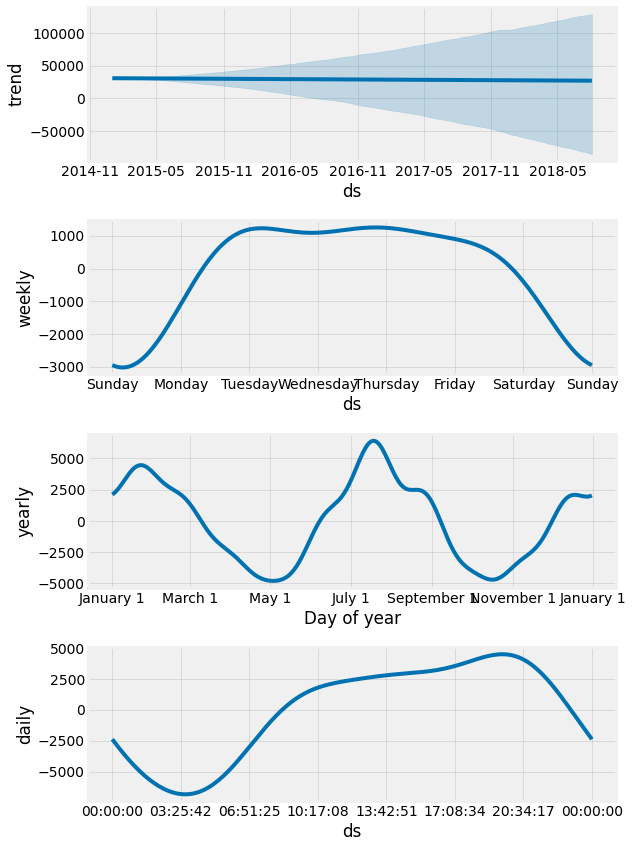

In [ ]:
#  
fig = model.plot_components(pjme_test_forecast)

Анализ прогнозирования

13. Сопоставим прогнозы с фактическими значениями в тестовой выборке
Dark  - это прошлые данные
*   Dark - это прошлые данные (черный цвет)
*   Red - это фактические, актуальные
*   Dark blue - это предсказание
*   Light blue - это неопределенность

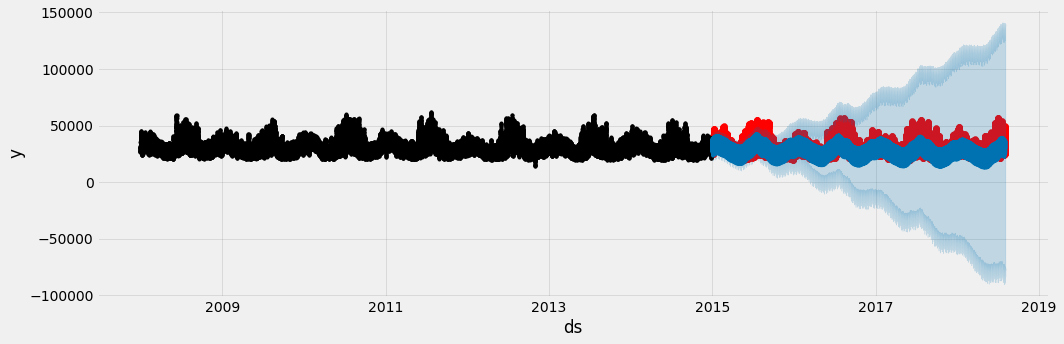

In [ ]:
# Сопоставим прогноз с фактическими данными
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.Datetime, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_forecast, ax=ax)

14. Сравним на графике прогнозы на апрель месяц с реальными.

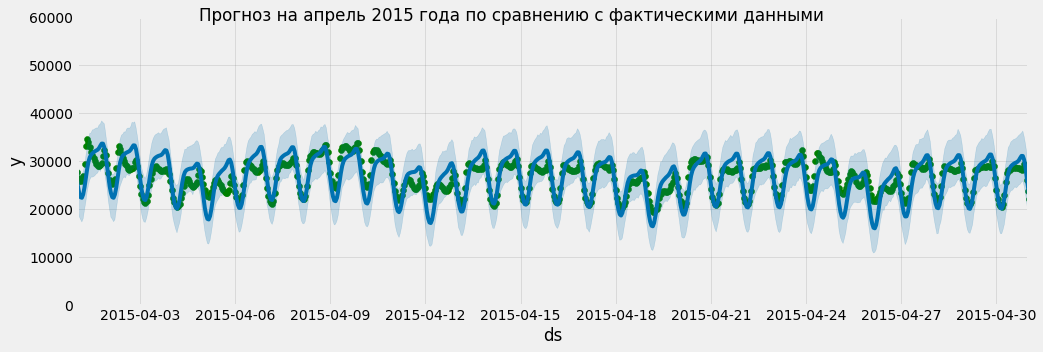

In [ ]:
# Сопоставьте прогноз с фактическими данными
from datetime import datetime
datetime_object = datetime.strptime('Jun 1 2005  1:33PM', '%b %d %Y %I:%M%p')

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.Datetime, pjme_test['PJME_MW'], color='g')
fig = model.plot(pjme_test_forecast, ax=ax)
ax.set_xbound(lower=datetime.strptime('04-01-2015', "%m-%d-%Y"),
              upper=datetime.strptime('05-01-2015', "%m-%d-%Y"))
ax.set_ylim(0, 60000)
plot = plt.suptitle('Прогноз на апрель 2015 года по сравнению с фактическими данными')

15. Сопоставим данные за первую неделю апреля с прогнозами модели

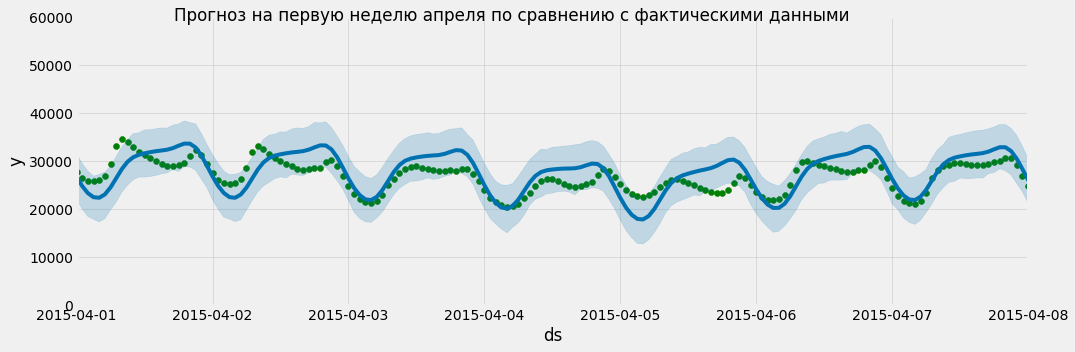

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.Datetime, pjme_test['PJME_MW'], color='g')
fig = model.plot(pjme_test_forecast, ax=ax)
ax.set_xbound(lower=datetime.strptime('04-01-2015', "%m-%d-%Y"), upper=datetime.strptime('04-08-2015', "%m-%d-%Y"))
ax.set_ylim(0, 60000)
plot = plt.suptitle('Прогноз на первую неделю апреля по сравнению с фактическими данными')

16. Вычислим MSE, MAE и MAPE (среднюю абсолютную процентную ошибку) для этой модели по тестовому набору данных

17. 
$$MAPE = \frac{1}{n}\sum_{t=1}^{n}|\frac{Y_t - \hat{Y_t}}{Y_t}|$$

In [ ]:
mse = mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_forecast['yhat'])

print("MSE на тестовой выборке: \n {}".format(mse))

MSE на тестовой выборке: 
 48948325.21211523


In [ ]:
mae = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_forecast['yhat'])

print("MAE на тестовой выборке: \n {}".format(mae))

MAE на тестовой выборке: 
 5464.6240741276315


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_forecast['yhat'])

print("MAPE на тестовой выборке : \n {}".format(mape))

MAPE на тестовой выборке : 
 16.96966125937518


Выводы

Мы исследовали данные временных рядов
Создали модель Prophet и использовали ее для составления прогнозов в выборках.
Оценили модель на основе набора данных с 3 показателями.



Дополнительные исследовния 


# Добавим праздники
Далее мы посмотрим, поможет ли добавление праздничных показателей точности модели. Prophet поставляется с параметром праздничных эффектов, который может быть предоставлен модели перед обучением.

Мы будем использовать встроенный календарь pandas USFederalHolidayCalendar для извлечения списка праздников

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=pjme_train.index.min(),
                              end=pjme_train.index.max())
test_holidays = cal.holidays(start=pjme_test.index.min(),
                             end=pjme_test.index.max())

In [ ]:
# Создадим фрейм данных со столбцами holiday, ds
 
pjme['is_holiday'] = pjme.date.isin([d.date() for d in cal.holidays()])
holiday_df = pjme.loc[pjme['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df.head()

,index,ds,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,holiday
0,0,2008-01-01,0,1,1,1,2008,1,1,1,USFederalHoliday
1,24,2009-01-01,0,3,1,1,2009,1,1,1,USFederalHoliday
2,192,2008-12-25,0,3,4,12,2008,360,25,52,USFederalHoliday
3,864,2008-11-27,0,3,4,11,2008,332,27,48,USFederalHoliday
4,1248,2008-11-11,0,1,4,11,2008,316,11,46,USFederalHoliday


In [ ]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [ ]:
# Настройка и тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train.reset_index() \
                            .rename(columns={'Datetime':'ds',
                                             'PJME_MW':'y'}))

Предсказания С Праздниками

In [ ]:
# Прогнозирование на обучающем наборе с помощью модели
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test.reset_index() \
                                    .rename(columns={'Datetime':'ds'}))

Построим график тренда с учетом праздничных дней

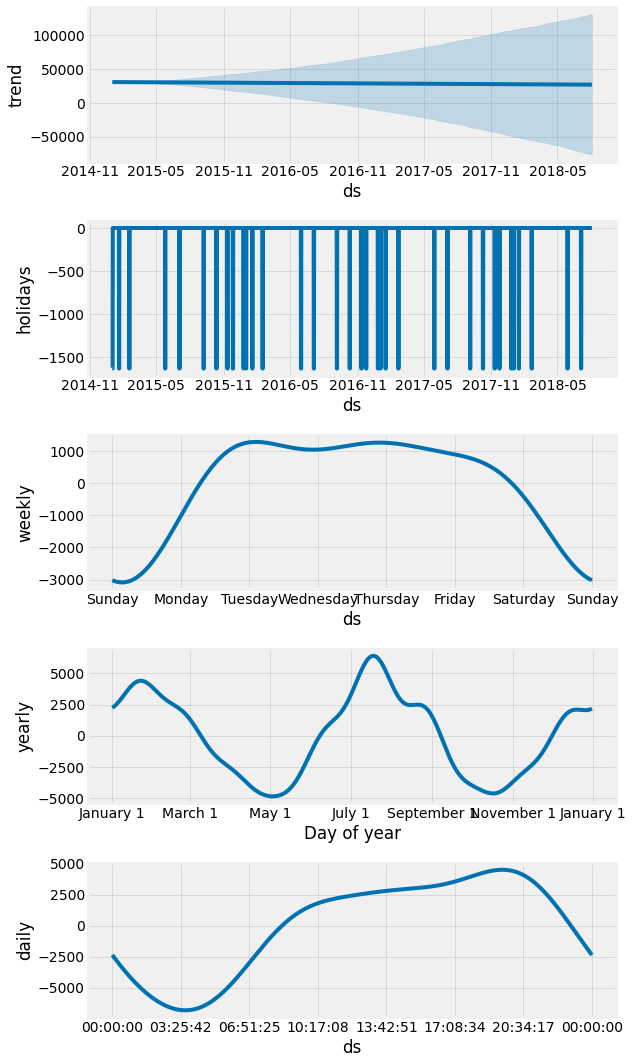

In [ ]:
fig2 = model_with_holidays.plot_components(pjme_test_fcst_with_hols)

# Метрики с учетом праздников


In [ ]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

49117710.88025762

In [ ]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

5477.6273848564915

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

17.009819878487757

Удивительно, но ошибка усилилась после добавления праздников.

Как видим, значения ошибок возросли, хоть и незначительно, в целом разница небольшая, но мы получили переобучение. Поэтому признак оказался неинформативным.

Возможно,  модель работала бы лучше, если бы мы специально определяли праздники вместо того, чтобы объединять их все вместе как "федеральные праздники США".

In [ ]:
holiday_df['date'] = holiday_df['ds'].dt.date

for hol, d in holiday_df.groupby('date'):
    holiday_list = d['ds'].tolist()
    hols_test = pjme_test.query('Datetime in @holiday_list')
    if len(hols_test) == 0:
        continue
    hols_pred = pjme_test_forecast.query('ds in @holiday_list')
    hols_pred_holiday_model = pjme_test_fcst_with_hols.query('ds in @holiday_list')
    non_hol_error = mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred['yhat'])
    hol_model_error = mean_absolute_error(y_true=hols_test['PJME_MW'],
                       y_pred=hols_pred_holiday_model['yhat'])
    diff = non_hol_error - hol_model_error
    print(f'Holiday: {hol:%B %d, %Y}:    \n MAE (non-holiday model): {non_hol_error:0.1f} \n MAE (Holiday Model): {hol_model_error:0.1f} \n Diff {diff:0.1f}')

Holiday: January 19, 2015:    
 MAE (non-holiday model): 1550.9 
 MAE (Holiday Model): 16.0 
 Diff 1534.8
Holiday: February 16, 2015:    
 MAE (non-holiday model): 12032.8 
 MAE (Holiday Model): 13570.1 
 Diff -1537.4
Holiday: May 25, 2015:    
 MAE (non-holiday model): 737.9 
 MAE (Holiday Model): 2207.1 
 Diff -1469.1
Holiday: July 03, 2015:    
 MAE (non-holiday model): 4100.3 
 MAE (Holiday Model): 2544.1 
 Diff 1556.2
Holiday: September 07, 2015:    
 MAE (non-holiday model): 2025.1 
 MAE (Holiday Model): 3501.5 
 Diff -1476.3
Holiday: October 12, 2015:    
 MAE (non-holiday model): 760.7 
 MAE (Holiday Model): 2229.8 
 Diff -1469.1
Holiday: November 11, 2015:    
 MAE (non-holiday model): 1005.0 
 MAE (Holiday Model): 602.5 
 Diff 402.5
Holiday: November 26, 2015:    
 MAE (non-holiday model): 621.3 
 MAE (Holiday Model): 894.9 
 Diff -273.5
Holiday: December 25, 2015:    
 MAE (non-holiday model): 5695.7 
 MAE (Holiday Model): 4161.8 
 Diff 1533.8
Holiday: January 01, 2016:    


Ошибки построения каждого прогноза помогают нам понять следующее:
Мы видим, что обе наши модели хорошо обобщают, но испытывают трудности в дни пикового спроса. Таких прогнозируется много дней. Попробуем выснить почему такое происходит.



Стоит учесть следующий факт периода:
29-30 октября ураган "Сэнди" вызвал сильные ветры и наводнения на значительной части восточной части Соединенных Штатов, в результате чего, по оценкам, 8 миллионов потребителей остались без электричества. Шторм, который обрушился на берег недалеко от Атлантик-Сити, штат Нью-Джерси, как ураган 1-й категории, в конечном итоге оставил без электричества множество домов и предприятий в Нью-Джерси (2,7 миллиона), Нью-Йорке (2,2 миллиона), Пенсильвании (1,2 миллиона), Коннектикуте (620 000), Массачусетсе (400 000), Мэриленде (290 000), Западной Вирджинии (268 000), Огайо (250 000) и Нью-Гемпшире (210 000). Также сообщалось о перебоях в подаче электроэнергии в ряде других штатов, включая Вирджинию, Мэн, Род-Айленд, Вермонт и округ Колумбия.
Поэтому, необходимо это учесть в нашем исследовании и стоит почистить данные от неверных показателей. 

In [ ]:
# Чистим данные
pjme_train['PJME_MW_clean'] = pjme_train['PJME_MW']
pjme_train.loc[pjme_train['PJME_MW'] < 19000, 'PJME_MW_clean'] = np.nan

# Тренируем модель на чистых данных
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW_clean':'y'})
         )

# Прогнозирование на обучающем наборе с помощью чистой модели
pjme_test_fcst_clean = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [ ]:
mse_clean = mean_squared_error(y_true=pjme_test['PJME_MW'],
                               y_pred=pjme_test_fcst_clean['yhat']
                              )
mae_clean = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                                y_pred=pjme_test_fcst_clean['yhat']
                               )
mape_clean = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                                            y_pred=pjme_test_fcst_clean['yhat'])
print(f'Очищенная модель данных имеет MSE {mse_clean:0.4f} - MAE {mae_clean:0.4f} - MAPE {mape_clean:0.4f}')

Очищенная модель данных имеет MSE 48839822.7037 - MAE 5457.1816 - MAPE 16.9490


После очистки данных мы видим что показатели улучшились, хоть и не намного. Можно сказать что после очистки мы видим небольшое улучшение показателей по сравнению с первой моделью. Дополнительная очистка данных наряду с праздниками показывает немного лучшие результаты, что и показали данные метрики.

Прогноз модели : с помощью ARIMA

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

 

import statsmodels.api as sm
from fbprophet import Prophet
import xgboost as xgb

from sklearn.metrics import mean_absolute_error

In [ ]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

def limit(data, frm, to):
    return data[(data.index>=frm)&(data.index<to)]

In [ ]:
energy_hourly = pd.read_csv('../content/drive/MyDrive/PJME_hourly.csv', 
                            index_col=[0], parse_dates=[0])
energy_hourly.sort_index(inplace=True)

t = energy_hourly.PJME_MW.copy()
t = t.drop(t.index[t.index.duplicated()])
freq_index = pd.date_range(start=t.index[0], end=t.index[-1], freq='H')
constructed = pd.Series(index=freq_index, name='PJME_MW')
constructed.update(t)
constructed.interpolate(inplace=True)
train, test = split_data(constructed, '01-Jul-2002')

train = limit(constructed, '03-01-2011', '04-01-2011')
test  = limit(constructed, '04-01-2011', '05-01-2011')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
model_A = sm.tsa.statespace.SARIMAX(constructed,
                                order=(1,1,1),
                                seasonal_order=(0,0,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_A = model_A.fit()
print('AIC =', results_A.aic) #AIC
#result_ARIMA = results.forecast(steps=test.shape[0])
forecast_A = results_A.forecast(steps=test.shape[0])

AIC = 2320356.238987909


In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
  
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(forecast_A, test.values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()


{'corr': -0.021298934800787567,
 'mae': 3210.484040098159,
 'mape': 0.11768360528391779,
 'me': 4.933706450972765,
 'minmax': 0.10613105129097566,
 'mpe': 0.01880498635083282,
 'rmse': 3778.663397370502}

2 вариант Арима модели

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(pjme["PJME_MW"], order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:              D.PJME_MW   No. Observations:                92794
Model:                 ARIMA(1, 1, 2)   Log Likelihood             -781001.135
Method:                       css-mle   S.D. of innovations           1093.963
Date:                Tue, 01 Mar 2022   AIC                        1562012.269
Time:                        16:20:16   BIC                        1562059.460
Sample:                             1   HQIC                       1562026.639
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0820     11.362      0.007      0.994     -22.188      22.352
ar.L1.D.PJME_MW     0.6200      0.005    132.430      0.000       0.611       0.629
ma.L1.D.PJME_MW     0.1098      

In [ ]:
# 1,1,1 ARIMA Model
model = ARIMA(pjme["PJME_MW"], order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:              D.PJME_MW   No. Observations:                92794
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -781269.923
Method:                       css-mle   S.D. of innovations           1097.137
Date:                Tue, 01 Mar 2022   AIC                        1562547.847
Time:                        16:24:16   BIC                        1562585.599
Sample:                             1   HQIC                       1562559.342
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0820     11.855      0.007      0.994     -23.154      23.318
ar.L1.D.PJME_MW     0.6795      0.003    210.404      0.000       0.673       0.686
ma.L1.D.PJME_MW     0.0551      

Давайте построим график остатков, чтобы убедиться в отсутствии закономерностей (то есть поищем постоянное среднее значение и дисперсию). Остаточные ошибки кажутся нормальными при почти нулевом среднем значении и равномерной дисперсии. Давайте построим график фактических значений по сопоставленным значениям с помощью plot_predict().

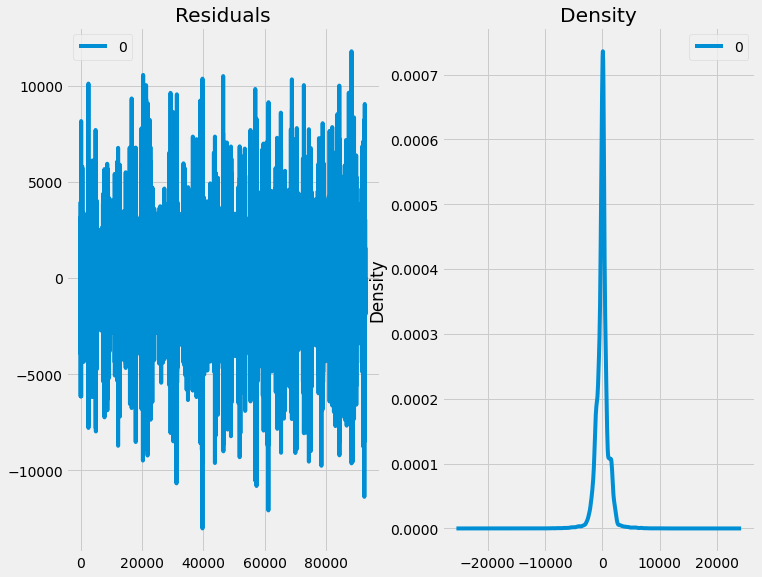

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

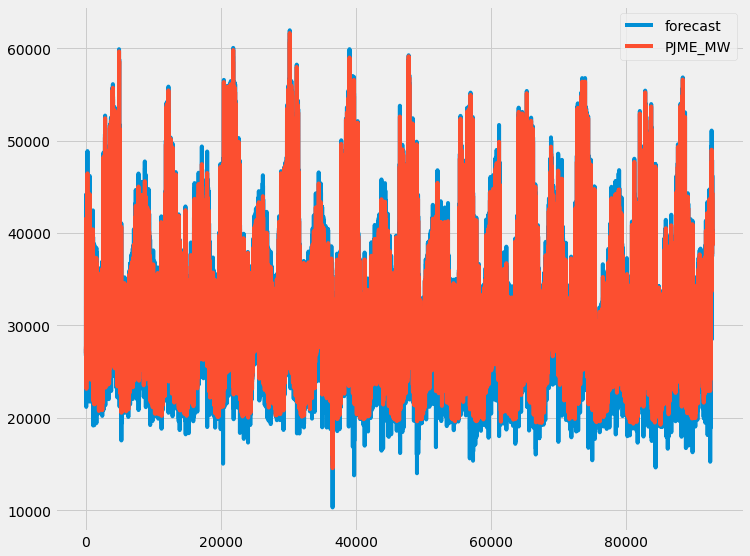

In [ ]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf

# Создаем Training and Test
train = pjme["PJME_MW"][:85]
test = pjme["PJME_MW"][85:]

Теперь мы построим модель ARIMA на основе обучающего набора данных, спрогнозироваем и построим ее график.

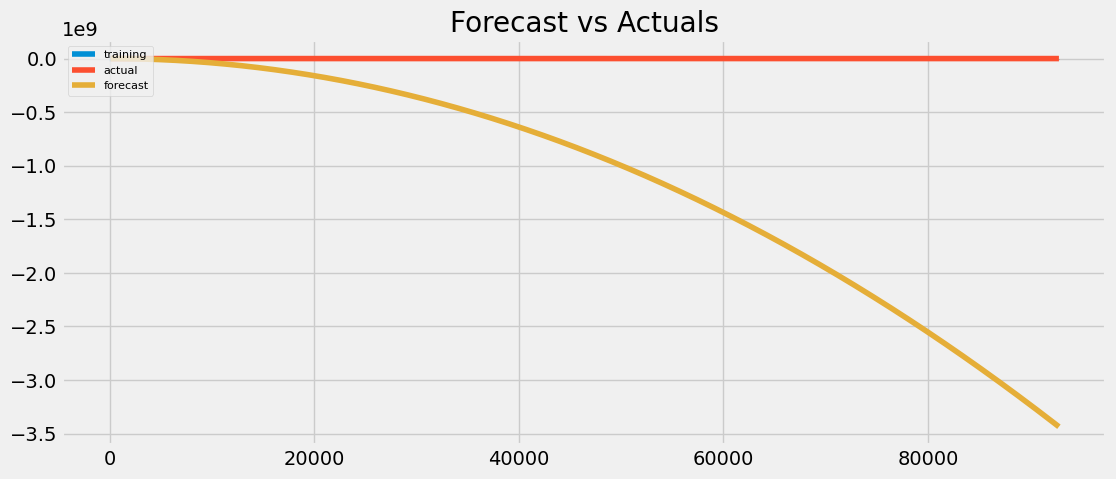

In [ ]:
# Построенте модели
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(92710, alpha=0.05)  # 95% conf

# Make as pandas series
# fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:             D2.PJME_MW   No. Observations:                   83
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -719.003
Method:                       css-mle   S.D. of innovations           1372.646
Date:                Tue, 01 Mar 2022   AIC                           1450.006
Time:                        16:35:52   BIC                           1464.519
Sample:                             2   HQIC                          1455.837
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.7976     14.603     -0.055      0.957     -29.418      27.823
ar.L1.D2.PJME_MW     0.6302      0.109      5.758      0.000       0.416       0.845
ar.L2.D2.PJME_MW     0.0497 

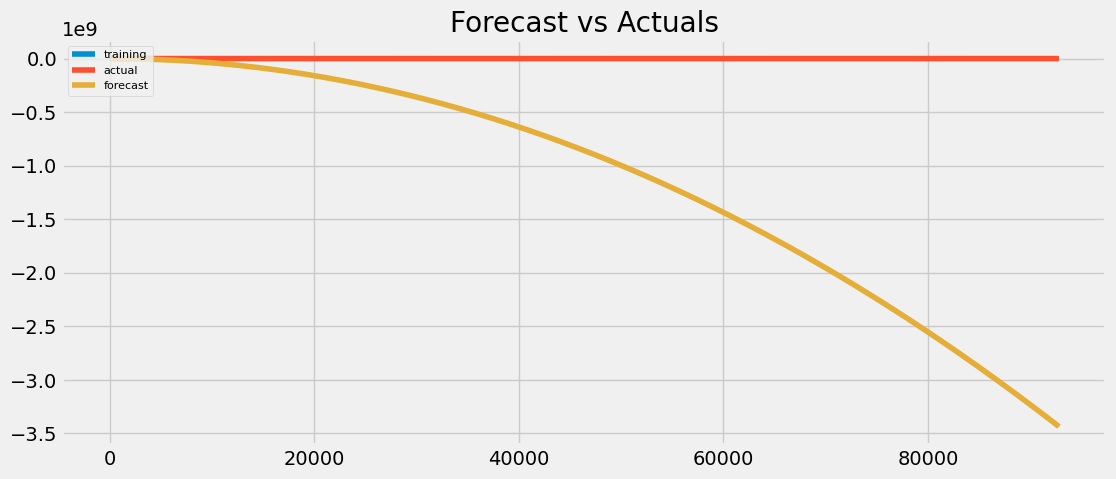

In [ ]:
# Build Model
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(92710, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

AIC сократился с 843 до 245, что хорошо. В основном, p-значения членов X меньше < 0,05, и это здорово. Так что в целом эта модель намного лучше.

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


{'acf1': 0.999967022706342,
 'corr': 0.0750061705795055,
 'mae': 2733340.3258017167,
 'mape': 89.95885003304258,
 'me': -2733339.930582801,
 'minmax': 89.95884957972942,
 'mpe': -89.95883481612763,
 'rmse': 3155172.8989283275}

Глядя на метрики можно сказать что данная модель не подходит для прогноза. Используем ее расширение - модель SARIMAX с наастройками сезонности и спец.параметров.

# Часть 3 : Прогноз модели : с помощью SARIMAX  <a class="anchor" id="chapter3"></a>

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# Configure matplotlib plotting
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] = 11, 9 #Changes default matplotlib plots to this size

In [ ]:
# Load my EDA helper function created to do some high-level analysis
class EDA():

    df = pd.DataFrame()
    
    def __init__(self, df):
        '''
        Creates EDA object for the DataFrame
        
        Note for time series data, have the index be the timestamp prior to creating this Object.
        
        :param df : DataFrame
        '''
        self.df = df
        
    def missing_values(self):
        '''
        Checks missing values
        
        :return DataFrame
        
        '''
        missing = self.df[self.df.isna().any(axis=1)]
        
        print("Missing values data")
        
        return missing
    
    def duplicate_values(self):
        duplicates = self.df[self.df.duplicated(subset=None, keep='first')==True]
        
        print("Duplicate values data")
        
        return duplicates
        
    def duplicate_indices(self):
        '''
        Check whether the indices have any duplicates
        
        :return DataFrame
        '''        
        duplicate_indices = self.df[self.df.index.duplicated()==True]
        
        print("Duplicate indices")
        
        return duplicate_indices
            
    def summary(self):
        '''
        Return summary/describe of DataFrame
        
        :return DataFrame
        '''
        df = self.df.reset_index() # Reset to include the index
        
        summary = df.describe(include='all').transpose()
        
        print("Summary metrics")
        
        return summary
    
    def pandas_profiling(self):
        import pandas_profiling
        
        self.df.profile_report(style={'full_width':True})  
    
    def histogram_KDE(self):
        ''' 
        :return seaborn plot
        '''       
        sns.pairplot(self.df, diag='kde')
        sns.distplot(kde=True, fit=[st.norm or st.lognorm])
        
    def outliers(self, col):
        ''' 
        Checks outliers - anything outside of 5% to 95% quartile range
        
        :param col : str
            Name of col to be tested
            
        :return DataFrame
        '''
        outliers = self.df[~self.df[col].between(self.df[col].quantile(.05), self.df[col].quantile(.95))]
        
        print("Outliers")
        
        return outliers
        
    def missing_timeseries_points(self, freq='D'):
        '''
        Checks whether there's any missing data points in continuous time series data.
        
        :param freq optional default = 'D' : str
            Frequency compliant with pandas formatting
        
        :return DataFrame
        '''
        # First create date range
        date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq=freq)

        # Now compare against dataset
        missing_timeseries = self.df.index[~self.df.index.isin(date_range)]
        
        print("Missing timeseries data")
        
        return missing_timeseries

    def corr_heatmap(df):
        fig, ax = plt.subplots(figsize=(10, 6))
        corr = self.df.corr()
        hm = sns.heatmap(round(corr,2), annot=True, cmap="coolwarm",fmt='.2f', linewidths=.05)
        fig.subplots_adjust(top=0.93)
        title = fig.suptitle('Wine Attributes Correlation Heatmap', fontsize=14)

        plt.show()

    def plot_time_series_seasonal_decomp(self, type='add'):
        '''
        Plots seasonal decomposition of timeseries data
        
        :return matplotlib Plot
        '''
        from statsmodels.tsa.seasonal import seasonal_decompose
        decomposition = seasonal_decompose(self.df, model='multiplicative')

        fig = decomposition.plot()
        plt.show()
   
    def time_series_ADF(self):            
        '''
        Returns Augmented Dickey-Fuller Test
        '''
        from statsmodels.tsa.stattools import adfuller as ADF

        series = data['KwH'] # ADF takes series, not DF

        result = ADF(series)

        print('ADF Statistic: %f4.2' % result[0])
        print('P-value %f4.2' % result[1])

In [ ]:
# Load the Data
data = pd.read_csv("/content/drive/MyDrive/PJME_hourly.csv")

data.set_index('Datetime',inplace=True)

data.index = pd.to_datetime(data.index)

data_copy = data.copy(deep=True) # Make a deep copy, including a copy of the data and the indices
data.head(10)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
2002-12-31 06:00:00,26222.0
2002-12-31 07:00:00,28702.0
2002-12-31 08:00:00,30698.0
2002-12-31 09:00:00,31800.0


In [ ]:
# Given there's no missing data, we can resample the data to daily level
daily_data = data.resample(rule='D').sum()

# Set frequency explicitly to D
daily_data = daily_data.asfreq('D')

daily_data.head(10)

,PJME_MW
Datetime,
2002-01-01,714857.0
2002-01-02,822277.0
2002-01-03,828285.0
2002-01-04,809171.0
2002-01-05,729723.0
2002-01-06,727766.0
2002-01-07,800012.0
2002-01-08,824710.0
2002-01-09,810628.0


In [ ]:
# First we split it up between train and test
# We will aim for a 12 month forecast horizon (ie predict the last 12 months in the dataset)
cutoff = '2017-08-03'

daily_data.sort_index()

train = daily_data[:cutoff]
test = daily_data[cutoff:]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import meanabs

# Equivalent to R's Auto ARIMA to get the optimal parameters
#import pmdarima as pm
#model = pm.auto_arima(htrain, seasonal=True, stationary=True, stepwise=True, trace=True, suppress_warnings=True)

# First we split it up between train and test
htrain = train['PJME_MW'] # SARIMAX takes series, not DF
htest = test['PJME_MW'] # SARIMAX takes series, not DF

# Next define hyperparameters. Default is AR model (1,0,0)(0,0,0,0)
p = 1 # AR order
d = 0 # I degree
q = 1 # MA window
P = 0 # AR seasonal order
D = 1 # I seasonal order
Q = 2 # MA seasonal order
m = 6 # Seasonality period length / 720 поставить

model = SARIMAX(
    htrain,
    order=(p, d, q),
    seasonal_order=(P, D, Q, 720)
    ,enforce_stationarity=False
    ,enforce_invertibility=False
).fit(
    maxiter=50 # Default is 50
)

results = model.get_prediction(start=htest.index[0], end=htest.index[-1], dynamic=False)
SARIMA_prediction_CI = results.conf_int(alpha=(1-0.8)) # 80% CI
SARIMA_prediction = results.predicted_mean
SARIMA_prediction = SARIMA_prediction.to_frame().rename(columns={0: 'PJME_MW'})

# Evaluate it's performance using Mean Absolute Error (MAE)
print("Finished training and predicting. MAE SARIMA: {:.20f}. AIC: {}. Parameters: p,d,q,P,D,Q,m: ".format(meanabs(htest, SARIMA_prediction['PJME_MW']), model.aic), p,d,q,P,D,Q,m)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Let's see what the model did
model.plot_diagnostics(figsize=(15, 12))
plt.show()

Важно отметить, что модель должна иметь некоррелированные и нормально распределенные остатки (то есть среднее значение должно быть равно нулю). То есть центральная точка остатков должна быть равна нулю, а график распределения (KDE) также должен быть центрирован на 0.

Давайте оценим результаты их.

In [ ]:
# Evaluate it's performance using Mean Absolute Error (MAE)
from statsmodels.tools.eval_measures import meanabs

print("MAE SARIMA: {:.20f}".format(meanabs(htest, SARIMA_prediction['PJME_MW'])))

MAE SARIMA: 131987.15927191788796335459


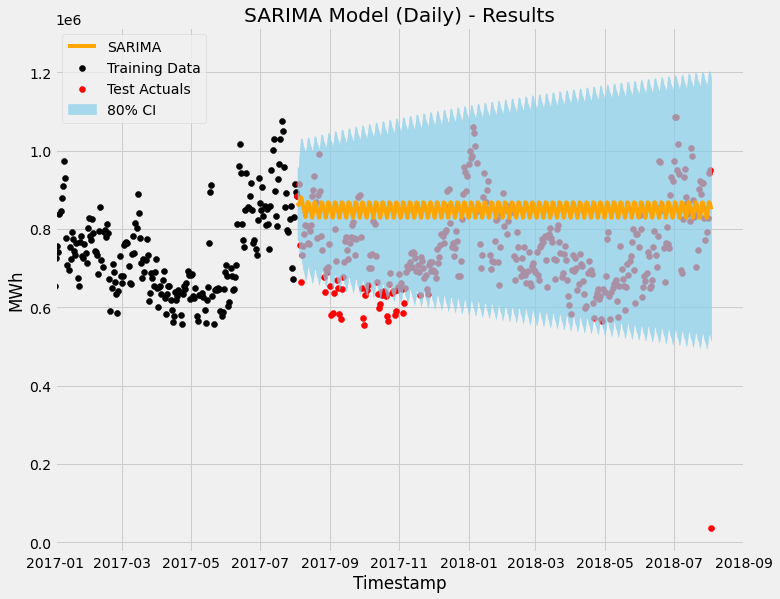

In [ ]:
# Let's visually see the results
plt.scatter(x=train.index, y=train['PJME_MW'], label='Training Data', color='black')
plt.scatter(x=test.index, y=test['PJME_MW'], label='Test Actuals', color='red')
plt.plot(SARIMA_prediction['PJME_MW'], label='SARIMA', color='orange')

# Plot Confidence Interval
plt.fill_between(
    SARIMA_prediction.index,
    SARIMA_prediction_CI['lower PJME_MW'],
    SARIMA_prediction_CI['upper PJME_MW'],
    color='skyblue',
    alpha=0.7, # 70% transparency
    label='80% CI'
)

# Plot Labels, Legends etc
plt.xlabel("Timestamp")
plt.ylabel("MWh")
plt.legend(loc='best')
plt.title('SARIMA Model (Daily) - Results')

# For clarify, let's limit to only 2017 onwards
plt.xlim(datetime(2017, 1, 1),datetime(2018, 9, 1))

plt.show()

Таким образом, вы можете видеть, что, несмотря на некоторую настройку, результаты не особенно хороши. Доверительный интервал очень велик, что указывает на то, что модель также не "уверена" в прогнозе.

Теперь давайте также посмотрим на Среднюю абсолютную процентную ошибку (MAPE)

В отличие от MAE, MAPE имеет проблемы в своих вычислениях, а именно, когда фактическое значение равно 0 (не может быть разделено на ноль), а отрицательные значения не могут превышать -100%.

Как бы то ни было, MAPE - это хорошая "проверка смысла", чтобы увидеть, какая модель пропорционально лучше.

In [ ]:
  
def MAPE(y_true, y_pred): 
    '''Function to calculate MAPE'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 

In [ ]:
print("MAPE SARIMA: {:.2f}%".format(MAPE(htest, SARIMA_prediction['PJME_MW'])))

MAPE SARIMA: 24.94%


In [ ]:
mse_clean = mean_squared_error(y_true=test['PJME_MW'],
                               y_pred= SARIMA_prediction['PJME_MW'])

In [ ]:
print(f'SARIMA модель имеет MSE {mse_clean:0.4f}')

SARIMA модель имеет MSE 23648465438.8249



# Часть 4 : Прогноз модели : с помощью LASSO (L1) Regression  <a class="anchor" id="chapter4"></a>

Регрессия ЛАССО включает регуляризацию и выбор признаков в свой алгоритм. Регуляризация - это метод, используемый в регрессионных алгоритмах, чтобы избежать переобучения.

In [ ]:
# Feature Engineering first

def preprocess_xgb_data(df, lag_start=1, lag_end=365):
    '''
    Takes data and preprocesses for XGBoost.
    
    :param lag_start default 1 : int
        Lag window start - 1 indicates one-day behind
    :param lag_end default 365 : int
        Lag window start - 365 indicates one-year behind
        
    Returns tuple : (data, target)
    '''
    # Default is add in lag of 365 days of data - ie make the model consider 365 days of prior data
    for i in range(lag_start,lag_end):
        df[f'PJME_MW {i}'] = df.shift(periods=i, freq='D')['PJME_MW']

    df.reset_index(inplace=True)

    # Split out attributes of timestamp - hopefully this lets the algorithm consider seasonality
    df['date_epoch'] = pd.to_numeric(df['Datetime']) # Easier for algorithm to consider consecutive integers, rather than timestamps
    df['dayofweek'] = df['Datetime'].dt.dayofweek
    df['dayofmonth'] = df['Datetime'].dt.day
    df['dayofyear'] = df['Datetime'].dt.dayofyear
    df['weekofyear'] = df['Datetime'].dt.weekofyear
    df['quarter'] = df['Datetime'].dt.quarter
    df['month'] = df['Datetime'].dt.month
    df['year'] = df['Datetime'].dt.year
    
    x = df.drop(columns=['Datetime', 'PJME_MW']) #Don't need timestamp and target
    y = df['PJME_MW'] # Target prediction is the load
    
    return x, y

In [ ]:
# So because we need the lag data, we need to preprocess then do the split
all_data = daily_data.copy()

# Create train test dataset using XGBoost preprocessing (365 days top 720 days lag)
feature, label = preprocess_xgb_data(all_data, lag_start=365, lag_end=720)

# We will aim for a 12 month forecast horizon (ie predict the last 365 days in the dataset)
train_feature = feature[:-365]
train_label = label[:-365]

test_feature = feature[-365:]
test_label = label[-365:]

train_feature = train_feature.fillna(0)
test_feature = test_feature.fillna(0)

# train_feature.drop(columns=['date_epoch']) #Don't need timestamp
# test_feature.drop(columns=['date_epoch']) #Don't need timestamp

# Scale dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_feature_scaled = scaler.fit_transform(train_feature)
test_feature_scaled = scaler.transform(test_feature)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To 

In [ ]:
# Create Time Series k-fold cross validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5) # in this case 5-fold

#Train and predict using LASSO
from sklearn.linear_model import LassoCV

model = LassoCV(
    alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,0.3, 0.6, 1]
    ,max_iter=1000 # 1000 iterations
    ,random_state=42
    ,cv=tscv
    ,verbose=True
)
model.fit(
    train_feature_scaled
    ,train_label
)
LASSO_prediction = test.copy()
LASSO_prediction['PJME_MW Prediction'] = model.predict(test_feature_scaled)
#LASSO_prediction = LASSO_prediction[['Datetime', 'PJME_MW Prediction']].set_index('Datetime')
#LASSO_prediction = LASSO_prediction.rename(columns={'PJME_MW Prediction': 'PJME_MW'})

LASSO_prediction

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2470974699101.017, tolerance: 1096685427.734284
  positive,
./usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2343576860701.928, tolerance: 1096685427.734284
  positive,
./usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2425017153468.9565, tolerance: 1096685427.734284
  positive,
./usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not con

85                                                              28602.0
86                                                              28427.0
87                                                              28289.0
88                                                              28535.0
89                                                              29787.0
                                            ...                        
92791                                                           43751.0
92792                                                           42402.0
92793                                                           40164.0
92794                                                           38608.0
PJME_MW Prediction    [890015.3160393987, 838777.8557516926, 806258....
Name: PJME_MW, Length: 92711, dtype: object

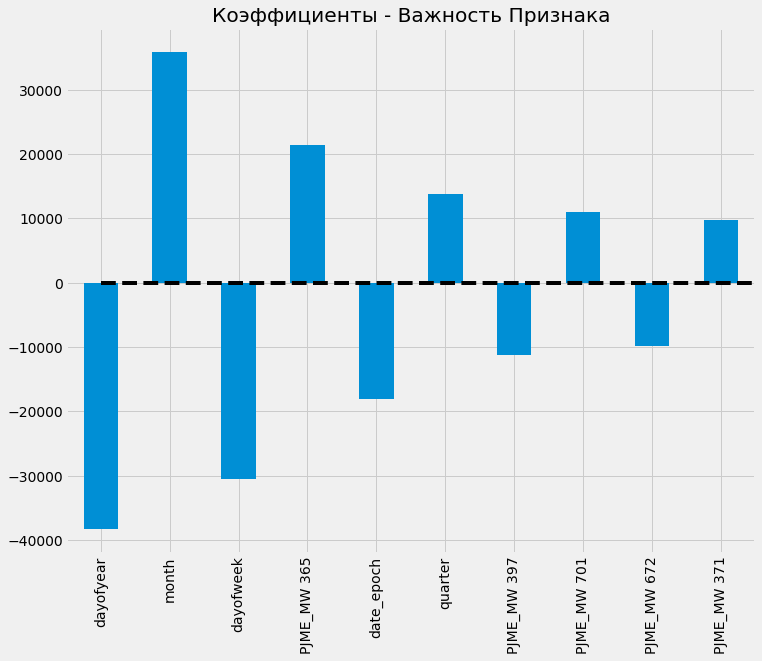

In [ ]:
# Plot feature importance by way of coefficients    

# Create DataFrame
coefs = pd.DataFrame(model.coef_, train_feature.columns)
coefs.columns = ["coef"]

# Only grab the Top 10 Coefficients
coefs["abs"] = coefs.coef.apply(np.abs)
coefs = coefs.sort_values(by="abs", ascending=False).head(10)
coefs = coefs.drop(["abs"], axis=1)

# Plot
coefs.coef.plot(kind='bar')

# Plot title and x-axis line
plt.title("Коэффициенты - Важность Признака")
plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [ ]:
def MAPE(y_true, y_pred): 
    '''Function to calculate MAPE'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
print("MAPE LASSO: {:.2f}%".format(MAPE(test_label, LASSO_prediction['PJME_MW Prediction'])))

MAPE LASSO: 14.50%


In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
  
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(LASSO_prediction['PJME_MW Prediction'], test_label.values)

{'corr': 0.6025292142423659,
 'mae': 62908.35600470739,
 'mape': 0.14500735733598932,
 'me': -2821.5933958703913,
 'minmax': 0.07686701485603054,
 'mpe': 0.06696659953972321,
 'rmse': 92173.65044531054}

Выводы  
Анализируя показатели оценки качества, стоит сказать следующее:

Чем меньше ошибка, тем лучше / точнее модель, поэтому в случае оценки по MAPE лучше показала модель LASSO (L1) Regression. Тем не менее, Prophet занимает хорошие позиции по метрикам MAE и RMSE

Мы предсказали потребление энергии, исследовали методы анализа временных рядов. Цель проекта можно считать выполненной.

In [ ]:
print('Оценка моделей с использованием метрик среднеквадратической ошибки (RMSE), средней абсолютной ошибки (MAE), , средняя абсолютная ошибка в процентах (MAPE)')
print()
print('1. МОДЕЛЬ Prophet') 
print('   Среднеквадратичная ошибка RMSE:', '48839822.7037')
print('   Средняя абсолютная ошибка MAE:', '5457.1816')
print('   Cредняя абсолютная ошибка в процентах MAPE:', '16.9490')
print()
print('2. МОДЕЛЬ ARIMA')
print('   Среднеквадратичная ошибка RMSE:', '3155172.8989283275')
print('   Средняя абсолютная ошибка MAE:', '2733340.3258017167')
print('   Cредняя абсолютная ошибка в процентах MAPE:', '89.95885003304258')
print()
print('3. МОДЕЛЬ SARIMAX')
print('   Среднеквадратичная ошибка RMSE:', '23648465438.8249')
print('   Средняя абсолютная ошибка MAE:', '131987.15927191788796335459')
print('   Cредняя абсолютная ошибка в процентах MAPE:', '24.94')
print()
print('4. LASSO (L1) Regression')
print('   Среднеквадратичная ошибка RMSE:', '92173.65044531054')
print('   Средняя абсолютная ошибка MAE:', '62908.35600470739')
print('   Cредняя абсолютная ошибка в процентах MAPE:', '14.50')

Оценка моделей с использованием метрик среднеквадратической ошибки (RMSE), средней абсолютной ошибки (MAE), , средняя абсолютная ошибка в процентах (MAPE)

1. МОДЕЛЬ Prophet
   Среднеквадратичная ошибка RMSE: 48839822.7037
   Средняя абсолютная ошибка MAE: 5457.1816
   Cредняя абсолютная ошибка в процентах MAPE: 16.9490

2. МОДЕЛЬ ARIMA
   Среднеквадратичная ошибка RMSE: 3155172.8989283275
   Средняя абсолютная ошибка MAE: 2733340.3258017167
   Cредняя абсолютная ошибка в процентах MAPE: 89.95885003304258

3. МОДЕЛЬ SARIMAX
   Среднеквадратичная ошибка RMSE: 23648465438.8249
   Средняя абсолютная ошибка MAE: 131987.15927191788796335459
   Cредняя абсолютная ошибка в процентах MAPE: 24.94

4. LASSO (L1) Regression
   Среднеквадратичная ошибка RMSE: 92173.65044531054
   Средняя абсолютная ошибка MAE: 14.50
   Cредняя абсолютная ошибка в процентах MAPE: 62908.35600470739
